# Torch to ONNX Conversion for Inference Optimization

ONNX Runtime is a performance-focused engine for ONNX models, which inferences efficiently across multiple platforms and hardware (Windows, Linux, and Mac and on both CPUs and GPUs). ONNX Runtime has proved to considerably increase performance over multiple models.

## Standard Imports

In [1]:
# Some standard imports
import io
import numpy as np

from torch import nn
import torch.utils.model_zoo as model_zoo
import torch.onnx

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import models, transforms
from torchvision.datasets.folder import make_dataset
from PIL import Image
import matplotlib.pyplot as plt
import time
import os
import copy

In [2]:
import onnxruntime
import onnx

## Data and Model Preparation

In [3]:
WEIGHT_PATH = './custom_model.pth'

In [4]:
# Initialize model with the pretrained weights
model = models.vgg16(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.classifier[-1].in_features
model.classifier[-1] = nn.Linear(num_ftrs, 5)



# Load model weights
model.load_state_dict(torch.load(WEIGHT_PATH,map_location=torch.device('cpu')))

if torch.cuda.is_available():
    model.cuda()

model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [5]:
# Define the dataloader for testing.
test_batch_size = 64
# test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=test_batch_size, shuffle=True, num_workers=4,pin_memory=True)

In [6]:
# Input to the model
x = torch.randn(test_batch_size, 3, 224, 224, requires_grad=True)
torch_out = model(x)

# ONNX Export testing

In [12]:
import onnx

onnx_model = onnx.load("./onnx_converted.onnx")
onnx.checker.check_model(onnx_model)

In [13]:
import onnxruntime

ort_session = onnxruntime.InferenceSession("./onnx_converted.onnx")

In [16]:
# Define the dataset class
class sg_food_dataset(torch.utils.data.dataset.Dataset):
    def __init__(self, root, class_id, transform=None):
        self.class_id = class_id
        self.root = root
        all_classes = sorted(entry.name for entry in os.scandir(root) if entry.is_dir())
        if not all_classes:
            raise FileNotFoundError(f"Couldn't find any class folder in {directory}.")
        self.classes = [all_classes[x] for x in class_id]
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}

        self.samples = make_dataset(self.root, self.class_to_idx, extensions=('jpg'))
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, target = self.samples[idx]
        with open(path, "rb") as f:
            sample = Image.open(f).convert('RGB')
        if self.transform is not None:
            sample = self.transform(sample)
        return sample, target


In [17]:
def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

In [18]:

# Data augmentation and normalization for training
data_transforms = {
    'train': transforms.Compose([
        # Define data preparation operations for training set here.
        # Tips: Use torchvision.transforms
        #       https://pytorch.org/vision/stable/transforms.html
        #       Normally this should at least contain resizing (Resize) and data format converting (ToTensor).
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # ImageNet prior
    ]),
    'val': transforms.Compose([
        # Define data preparation operations for testing/validation set here.
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # ImageNet prior
    ]),
}

data_dir = os.path.join('./', 'sg_food')
subfolder = {'train': 'train', 'val': 'val'}

# Define the dataset
selected_classes = [3,5,7,8,9]
n_classes = len(selected_classes)
image_datasets = {x: sg_food_dataset(root=os.path.join(data_dir, subfolder[x]),
                                     class_id=selected_classes,
                                     transform=data_transforms[x]) 
                  for x in ['train', 'val']}
class_names = image_datasets['train'].classes
print('selected classes:\n    id: {}\n    name: {}'.format(selected_classes, class_names))

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

selected classes:
    id: [3, 5, 7, 8, 9]
    name: ['Hokkien Prawn Mee', 'Laksa', 'Oyster Omelette', 'Roast Meat Rice', 'Roti Prata']


In [19]:
test_dir = './sg_food/test'

# Define the test set.
test_dataset = sg_food_dataset(root=test_dir, class_id=selected_classes, transform=data_transforms['val'])
test_sizes = len(test_dataset)

# Define the dataloader for testing.
test_batch_size = 64
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=test_batch_size, shuffle=True, num_workers=0)

In [12]:
test_acc = 0

print('Evaluation')
print('-' * 10)

y_true = []
y_pred = []

wrong_detections = []
correct_detections = []

time_total= 0

with torch.no_grad():
    # Iterate over the testing dataset.
    for (inputs, labels) in test_loader:
        inputs = inputs.to(device)
        ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(inputs)}
        time_start = time.time()
        ort_outs = ort_session.run(None, ort_inputs)
        time_total += time.time() - time_start
#         print(type(ort_outs))
#         print(len(ort_outs[0]))
        
        # Predict on the test set
        # outputs = model(inputs)
        output_tensors = torch.FloatTensor(ort_outs[0])
        _, preds = torch.max(output_tensors, 1)
#         print(preds)
        # preds = ort_outs
        
        # Confusion Matrix
        
        y_true.extend(preds.numpy())
        y_pred.extend(labels.data.numpy())
        
        test_acc += torch.sum(preds == labels.data)

print('Eval time...')
print(time_total)
# Compute the testing accuracy
test_acc = test_acc.double() / test_sizes
print('Testing Acc: {:.4f}'.format(test_acc))

Evaluation
----------
Eval time...
125.17501211166382
Testing Acc: 0.8318


## Torch based inference

In [12]:


model.eval()

test_acc = 0

print('Evaluation')
print('-' * 10)

y_true = []
y_pred = []

wrong_detections = []
correct_detections = []

time_now= time.time()


time_total= 0

with torch.no_grad():
    # Iterate over the testing dataset.
    for (inputs, labels) in test_loader:
        inputs = inputs.to(device)
        # Predict on the test set
        time_start = time.time()
        outputs = model(inputs)
        time_total += time.time() - time_start
        _, preds = torch.max(outputs, 1)
        preds = preds.cpu()
        
        # Confusion Matrix
        
        y_true.extend(preds.numpy())
        y_pred.extend(labels.data.numpy())
        
        test_acc += torch.sum(preds == labels.data)

print('Eval time...')
print(time.time()-time_now)
# Compute the testing accuracy
test_acc = test_acc.double() / test_sizes
print('Testing Acc: {:.4f}'.format(test_acc))

Evaluation
----------
Eval time...
208.15612721443176
Testing Acc: 0.8318


# Benchmarking Runtimes

In [6]:
from timeit import timeit

In [7]:
import numpy as np

In [8]:
# x = torch.randn(test_batch_size, 3, 224, 224, requires_grad=True)
data = np.random.rand(test_batch_size,3,224,224).astype(np.float32)
torch_data = torch.from_numpy(data)

In [23]:
def torch_inf():
    model(torch_data)

def onnx_inf():
    ort_inputs = {ort_session.get_inputs()[0].name: data}
    ort_outs = ort_session.run(None, ort_inputs)

In [28]:
n = 20

In [ ]:
torch_t = timeit(lambda : torch_inf(), number=n)/20

In [22]:
torch_t

12.876783071699998

In [24]:
onnx_t = timeit(lambda : onnx_inf(), number=n)/20

print(f"PyTorch {torch_t} VS ONNX {onnx_t}")

PyTorch 12.876783071699998 VS ONNX 7.9055955048500035


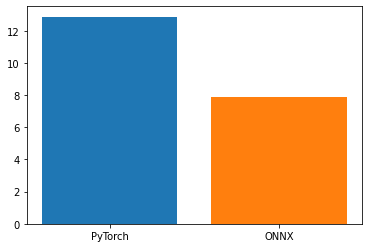

In [25]:
import matplotlib.pyplot as plt

plt.figure()

frameworks = ["PyTorch", "ONNX"]
times = [torch_t, onnx_t]

plt.bar(frameworks[0], times[0])
plt.bar(frameworks[1], times[1])
plt.show()

In [26]:
(torch_t-onnx_t)/torch_t

0.3860581900906168

In [27]:
(208.156-125.75)/208.156

0.39588577797421165

# Testing Deployment

In [3]:
onnx_model = onnx.load("./deployment/onnx_deployment.onnx")
onnx.checker.check_model(onnx_model)
ort_session = onnxruntime.InferenceSession("./deployment/onnx_deployment.onnx")

In [8]:
import cv2
img = cv2.imread('./Roti Prata.jpg',0)
dim = (224,224)

In [12]:
# resize image
resized_img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA).astype(np.float32)

In [20]:
inputs,labels = test_dataset[0]

In [26]:
inputs = to_numpy(inputs)

In [28]:
inputs[0]

array([[ 0.7590547 ,  0.74193   ,  0.7590547 , ..., -0.6622999 ,
        -0.6109256 , -0.5424266 ],
       [ 0.7590547 ,  0.7590547 ,  0.7761795 , ..., -0.57667613,
        -0.4054286 , -0.33692956],
       [ 0.7590547 ,  0.74193   ,  0.7590547 , ..., -0.30268008,
        -0.14855729, -0.09718303],
       ...,
       [ 1.3070468 ,  0.9816765 ,  0.5878072 , ..., -0.04580877,
        -0.6109256 , -0.79929787],
       [ 0.9988013 ,  0.6563062 ,  0.33093593, ...,  0.2624369 ,
        -0.45680285, -0.79929787],
       [ 0.6563062 ,  0.57068247,  0.2966864 , ...,  0.63918144,
        -0.16568205, -0.6280504 ]], dtype=float32)

In [29]:
resized_img

array([[164., 165., 166., ..., 255., 255., 255.],
       [165., 164., 164., ..., 255., 255., 255.],
       [165., 164., 164., ..., 255., 255., 255.],
       ...,
       [217., 216., 216., ..., 255., 255., 255.],
       [218., 217., 217., ..., 255., 255., 255.],
       [218., 218., 217., ..., 255., 255., 255.]], dtype=float32)

In [34]:
# deploy_dataset = sg_food_dataset(root='./deploy_test', class_id=selected_classes, transform=data_transforms['val'])
# deploy_batch_size = 1
# deploy_loader = torch.utils.data.DataLoader(deploy_dataset, batch_size=deploy_batch_size, shuffle=True, num_workers=0)

In [35]:
resized_img /= 255.

In [38]:
resized_img

array([[0.6431373 , 0.64705884, 0.6509804 , ..., 1.        , 1.        ,
        1.        ],
       [0.64705884, 0.6431373 , 0.6431373 , ..., 1.        , 1.        ,
        1.        ],
       [0.64705884, 0.6431373 , 0.6431373 , ..., 1.        , 1.        ,
        1.        ],
       ...,
       [0.8509804 , 0.84705883, 0.84705883, ..., 1.        , 1.        ,
        1.        ],
       [0.85490197, 0.8509804 , 0.8509804 , ..., 1.        , 1.        ,
        1.        ],
       [0.85490197, 0.85490197, 0.8509804 , ..., 1.        , 1.        ,
        1.        ]], dtype=float32)

In [36]:
ort_inputs = {ort_session.get_inputs()[0].name: resized_img}

In [37]:
ort_outs = ort_session.run(None, ort_inputs)

InvalidArgument: [ONNXRuntimeError] : 2 : INVALID_ARGUMENT : Invalid rank for input: input Got: 2 Expected: 4 Please fix either the inputs or the model.

In [73]:
# img = cv2.imread('./sg_food/test/Hokkien Prawn Mee/Hokkien Prawn Mee(28).jpg',cv2.COLOR_BGR2RGB)
f = './sg_food/test/Hokkien Prawn Mee/Hokkien Prawn Mee(28).jpg'
img = Image.open(f).convert('RGB')
transform_img = transforms.Compose([
        # Define data preparation operations for testing/validation set here.
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # ImageNet prior
    ])
input_img = transform_img(img)
input_img = input_img.unsqueeze_(0)
input_img =input_img.to('cpu')

In [74]:
type(input_img)

torch.Tensor

In [75]:
ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(input_img)}

In [76]:
ort_outs = ort_session.run(None, ort_inputs)

In [77]:
ort_outs

[array([[ 5.582136 ,  5.463295 , -6.272268 , -0.6216311, -4.644254 ]],
       dtype=float32)]

In [78]:
output_tensors = torch.FloatTensor(ort_outs[0])
_, preds = torch.max(output_tensors, 1)

In [79]:
preds= preds.numpy()

In [80]:
class_names[preds[0]]

'Hokkien Prawn Mee'